# Multi-Class Image Classification Model for Brain Tumor MRI Using TensorFlow Take 2
### David Lowe
### February 28, 2023

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Brain Tumor MRI Images Dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: The main product of grapevines is grapes that are consumed fresh or processed. In addition, grapevine leaves are harvested once a year as a by-product. Therefore, the species of grapevine leaves are essential factors in price and taste. The research team deployed deep learning-based classification models in this study to identify grapevine leaves. For this study, 500 images of vine leaves make up the dataset.

ANALYSIS: The MobileNetV3Large model's performance achieved an accuracy score of 99.21% after five epochs using the training dataset. When we applied the model to the validation dataset, the model achieved an accuracy score of 90.46%.

CONCLUSION: In this iteration, the TensorFlow MobileNetV3Large CNN model appeared suitable for modeling this dataset.

Dataset ML Model: Multi-Class classification with numerical features

Dataset Used: Brain Tumor MRI Image Dataset

Dataset Reference: https://www.kaggle.com/datasets/mahdinavaei/brain-tumor-mri-images-huge

One source of potential performance benchmarks: https://www.kaggle.com/datasets/mahdinavaei/brain-tumor-mri-images-huge/code

# Task 1 - Prepare Environment

In [1]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


In [2]:
# Retrieve memory configuration information
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 89.6 gigabytes of available RAM



In [3]:
# Retrieve GPU configuration information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Fri Feb 24 16:15:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import math
# import boto3
import zipfile
from datetime import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [7]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.1

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCHS = 10
BATCH_SIZE = 32
# CLASS_LABELS = []
# CLASS_NAMES = []
# RAW_IMAGE_SIZE = (250, 250)
TARGET_IMAGE_SIZE = (224, 224)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

# Define the labels to use for graphing the data
TRAIN_METRIC = "accuracy"
VALIDATION_METRIC = "val_accuracy"
TRAIN_LOSS = "loss"
VALIDATION_LOSS = "val_loss"

# Define the directory locations and file names
STAGING_DIR = 'staging/'
TRAIN_DIR = 'staging/brain tumor MRI images/train'
VALID_DIR = 'staging/brain tumor MRI images/val'
# TEST_DIR = ''
TRAIN_DATASET = 'archive.zip'
# VALID_DATASET = ''
# TEST_DATASET = ''
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.11.0


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [10]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [11]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/

if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-mahdinavaei-brain-tumor-mri/archive.zip

zip_ref = zipfile.ZipFile(TRAIN_DATASET, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

In [12]:
CLASS_LABELS = os.listdir(TRAIN_DIR)
print(CLASS_LABELS)
NUM_CLASSES = len(CLASS_LABELS)
print('Total number of classes detected:', NUM_CLASSES)

['Meningioma', 'Glioma', 'Pituitary tumor']
Total number of classes detected: 3


In [13]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    print('Number of training images for', c_label, ':', len(os.listdir(training_class_dir)))
    print('Training samples for', c_label, ':', training_class_files[:5],'\n')

Number of training images for Meningioma : 5951
Training samples for Meningioma : ['Meningioma_original_savedImage2859.png_b412d13b-2092-492d-a308-add63eab8a47.png', 'Meningioma_original_savedImage459.png_e7575a86-90af-494f-b779-d42fb56743bf.png', 'Meningioma_original_savedImage2361.png_8aaece9d-d1b9-4884-9e56-efefb2a7909e.png', 'Meningioma_original_2349.png_0374b6b5-fd14-423f-b4e0-46588548338f.png', 'Meningioma_original_savedImage2997.png_4cd1d708-10fe-4aa8-be91-64f94f69027d.png'] 

Number of training images for Glioma : 6301
Training samples for Glioma : ['271.png', 'Glioma_original_1859.png_284d9893-ec05-486f-80db-8dca1c97287a.png', 'Glioma_original_1961.png_784230a8-e4e1-4672-a22e-367992860803.png', 'Glioma_original_309.png_300d30c2-8fea-4aad-bde9-ba771ddc65a2.png', 'Glioma_original_537.png_fff72f95-5d25-429a-96d0-90b5440df808.png'] 

Number of training images for Pituitary tumor : 6146
Training samples for Pituitary tumor : ['Pituitary tumor_original_998.png_c2b462c0-9b84-4f17-aba

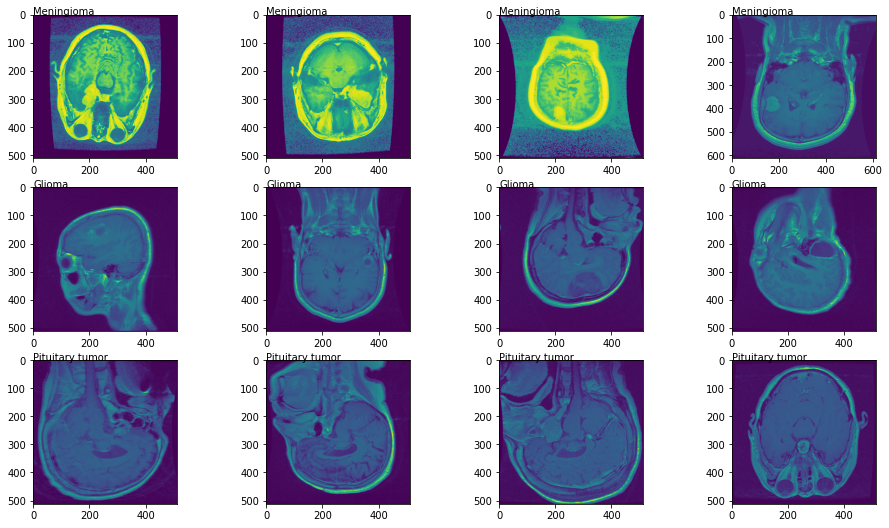

In [14]:
# Plot some training images from the dataset
nrows = len(CLASS_LABELS)
ncols = 4
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    for j in range(ncols):
        training_examples.append(training_class_dir + '/' + training_class_files[j])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.text(0, 0, example_labels[i])
    # sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [15]:
datagen_kwargs = dict(rescale=1./255)
training_datagen = ImageDataGenerator(**datagen_kwargs)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="categorical")

do_data_augmentation = False
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=45,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          **dataflow_kwargs)
print('Number of training image batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_directory(directory=VALID_DIR,
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              **dataflow_kwargs)
print('Number of validation image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 18398 images belonging to 3 classes.
Number of training image batches per epoch of modeling: 575
Loading and pre-processing the validation images...
Found 828 images belonging to 3 classes.
Number of validation image batches per epoch of modeling: 26


In [16]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [17]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [18]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [TRAIN_LOSS, TRAIN_METRIC]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == TRAIN_LOSS:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0, 1])
        plt.legend()

In [19]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, dense_nodes=2048,
                    classifier_activation=CLASSIFIER_ACTIVATION, loss_param=DEFAULT_LOSS,
                    opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.MobileNetV3Large(include_top=False, weights='imagenet', input_shape=input_param)
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(keras.layers.Flatten())
    nn_model.add(keras.layers.Dense(dense_nodes, activation='relu')),
    nn_model.add(keras.layers.Dense(output_param, activation=classifier_activation))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [20]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
baseline_model = create_nn_model()
baseline_model_history = baseline_model.fit(training_generator,
                                            epochs=MAX_EPOCHS,
                                            validation_data=validation_generator,
                                            verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Epoch 1/10
575/575 [==============================] - 119s 150ms/step - loss: 0.4144 - accuracy: 0.8981 - val_loss: 1.2824 - val_accuracy: 0.3720
Epoch 2/10
575/575 [==============================] - 85s 148ms/step - loss: 0.0706 - accuracy: 0.9740 - val_loss: 2.3175 - val_accuracy: 0.3889
Epoch 3/10
575/575 [==============================] - 84s 147ms/step - loss: 0.0504 - accuracy: 0.9817 - val_loss: 2.5345 - val_accuracy: 0.5350
Epoch 4/10
575/575 [==============================] - 85s 148ms/step - loss: 0.0496 - accuracy: 0.9824 - val_loss: 3.8669 - val_accuracy: 0.4734
Epoch 5/10
575/575 [==============================] - 84s 147ms/step - loss: 0.0314 - accuracy: 0.9873 - val_loss: 4.4515 - val_accuracy: 0.5978
Epoch 6/10
575/575 [==============================] - 84s 147ms/step - loss: 0.0234 - accuracy: 0.9910 - val_loss: 2.7466 - val_accuracy: 0.6401
Epoch 7/10
575/575 [==============================] - 85s 147ms/step - loss: 0.0330 - accuracy: 0.9884 - val_loss: 1.4291 - val_a

In [21]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 47040)             0         
                                                                 
 dense (Dense)               (None, 2048)              96339968  
                                                                 
 dense_1 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 99,342,467
Trainable params: 99,318,067
Non-trainable params: 24,400
_________________________________________________________________


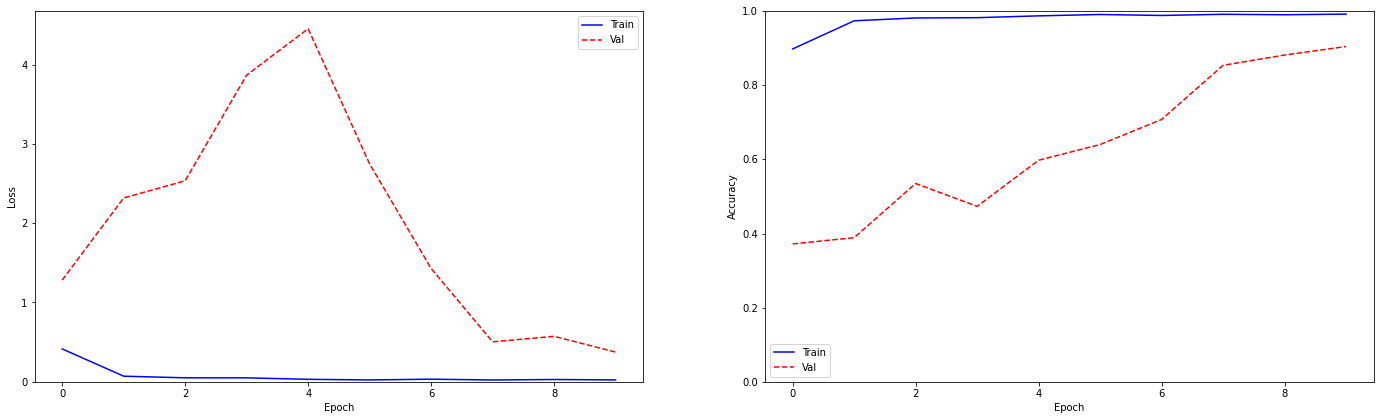

In [22]:
plot_metrics(baseline_model_history)

In [23]:
# if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Tune and Optimize Models

In [24]:
# if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Tune and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [25]:
# Not applicable for this iteration of modeling

In [26]:
# if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Tune and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [27]:
# if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [28]:
# Not applicable for this iteration of modeling

In [29]:
# if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [30]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:14:57.896051
